In [1]:
from utils.train import GAN
import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
import torch
from sklearn.metrics import mean_squared_error

/home/xusj/miniconda3/envs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
target2ckpt = {
    'Google': 'lightning_logs/version_46/checkpoints/epoch=852-step=18766.ckpt',
    'Apple': 'lightning_logs/version_51/checkpoints/epoch=916-step=20174.ckpt',
    'Amazon': 'lightning_logs/version_48/checkpoints/epoch=639-step=14080.ckpt',
    'Microsoft': 'lightning_logs/version_49/checkpoints/epoch=593-step=13068.ckpt',
}

In [6]:
target = 'Apple'
ckpt_path = target2ckpt[target]
model = GAN.load_from_checkpoint(ckpt_path)
model.eval()
model.freeze()
X, Y = model.dataset[:]
y_pred = model(X.to(model.device))
y_true = model.raw_dataset.y_scaler.inverse_transform(Y[:, model.num_days_for_predict].cpu()).flatten()
y_pred = model.raw_dataset.y_scaler.inverse_transform(y_pred.cpu()).flatten()

In [7]:
split = int(len(y_pred)*0.8)
y_train_pred, y_test_pred = y_pred[:split], y_pred[split:]
y_train, y_test = y_true[:split], y_true[split:]
train_RMSE = mean_squared_error(y_train, y_train_pred, squared=False)
test_RMSE = mean_squared_error(y_test, y_test_pred, squared=False)
standard_RMSE = mean_squared_error(y_true[1:], y_true[:-1], squared=False)
train_standard_RMSE = mean_squared_error(y_train[1:], y_train[:-1], squared=False)
test_standard_RMSE = mean_squared_error(y_test[1:], y_test[:-1], squared=False)
print('target:', target)
print("train RMSE:", train_RMSE)
print("test RMSE:", test_RMSE)
print("standard RMSE:", standard_RMSE)
print("train standard RMSE:", train_standard_RMSE)
print("test standard RMSE:", test_standard_RMSE)
print("train RMSE / standard RMSE:", train_RMSE/train_standard_RMSE)
print("test RMSE / standard RMSE:", test_RMSE/test_standard_RMSE)


target: Apple
train RMSE: 5.226389534761822
test RMSE: 9.42347294371088
standard RMSE: 2.316641005189636
train standard RMSE: 2.1648560890732442
test standard RMSE: 2.828606700678385
train RMSE / standard RMSE: 2.414197212064656
test RMSE / standard RMSE: 3.3314892952246944


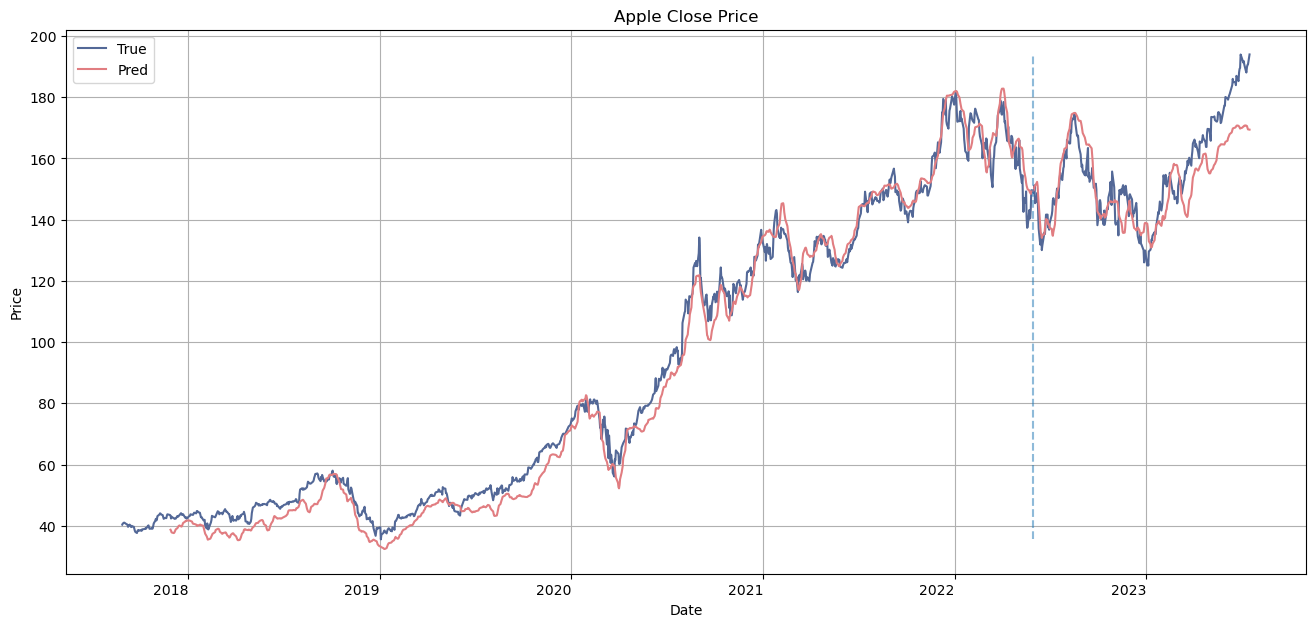

In [8]:
df = model.raw_dataset.df
df[f'{target} Close Pred'] = None
df.iloc[-len(y_pred):, -1] = y_pred
df[f'{target} Close'].plot(figsize=(16,8),label=f'True', color='#536897')
df[f'{target} Close Pred'].plot(figsize=(16,8),label=f'Pred', color='#E17D81', rot=0)

split = df.index[int(len(df) * model.hparams.train_size)]
plt.plot((split, split), (df[f'{target} Close'].min(), df[f'{target} Close'].max()), linestyle='--', alpha=0.5)
plt.grid()
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'{target} Close Price')
plt.savefig(f'images/{target} Close Price Prediction.png', dpi=300, bbox_inches='tight')

,Apple Close,Apple Close Pred
2022-06-16,130.059998,134.055139
2022-08-18,174.149994,174.890017
2023-01-11,133.490005,131.297957
2023-06-23,186.679993,170.783199


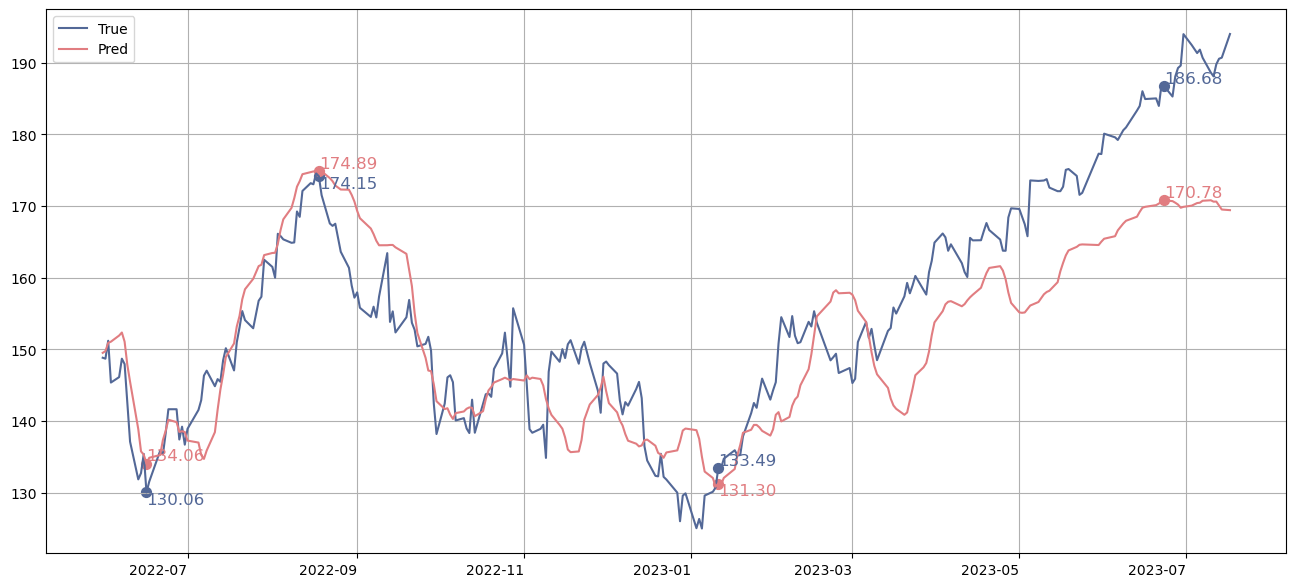

In [109]:
df[f'{target} Close'][split:].plot(figsize=(16,8),label=f'True', color='#536897', rot=0, grid=True)
df[f'{target} Close Pred'][split:].plot(figsize=(16,8),label=f'Pred', color='#E17D81', rot=0, grid=True)

pred_indices = pd.DatetimeIndex(['2022-06-16', '2022-08-18', '2023-01-11', '2023-06-23'])

plt.scatter(pred_indices, df[f'{target} Close'][pred_indices], color='#536897', s=50)
plt.scatter(pred_indices, df[f'{target} Close Pred'][pred_indices], color='#E17D81', s=50)
plt.legend()

for date in pred_indices:
    pred = df[f'{target} Close Pred'][date]
    true = df[f'{target} Close'][date]
    plt.text(date, pred, f'{pred:.2f}', color='#E17D81', fontsize=12, va='bottom' if pred > true or abs(pred-true) > 0.05*true else 'top')
    plt.text(date, true, f'{true:.2f}', color='#536897', fontsize=12, va='bottom' if pred < true or abs(pred-true) > 0.05*true else 'top')
plt.savefig(f'images/{target} Close Price Test Set Prediction Zoom.png', dpi=300, bbox_inches='tight')
df.loc[pred_indices, [f'{target} Close', f'{target} Close Pred']]